# Assignment 3, Eric Johansson & Max Sonnelid

# Introduction

The machine learning task that will be addressed in this assignment is to develop a text classifier that determines whether a given textual comment expresses an opinion that is positive or negative towards COVID-19 vaccination. The data has been collected by participants of this course from youtube comments of videos discussing COVID vaccines. 

# Task 1 -  Working with a dataset with categorical features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Reading the data

In [2]:
from sklearn.model_selection import train_test_split

training_data_small = pd.read_csv("data/a3_first_sample.tsv", sep='\t', skiprows=0,  header=None)
training_data_large = pd.read_csv("data/a3_train_final.tsv", sep='\t', skiprows=0,  header=None)
test_data = pd.read_csv("data/a3_test.tsv", sep='\t', skiprows=0,  header=None)


training_data_small.columns = ['Pos/Neg', 'Comment']
training_data_large.columns = ['Pos/Neg', 'Comment']
test_data.columns = ['Pos/Neg', 'Comment']

In [3]:
training_data_large.shape

(8788, 2)

In [4]:
def calculate_mean(numbers):
    sum = 0
    only_neg = True

    for number in numbers:
        if (float(number) >= 0):
            sum += float(number)
            only_neg = False
    mean = sum/len(numbers)

    if (only_neg == True):
        return -1
    if (mean >= 0.5):
        return 1
    else:
        return 0

def conv_annotation(column):
    res = []
    for row in column:
        res.append(calculate_mean(row.split("/")))
    return pd.DataFrame(res)
    

In [5]:
training_data_large['Pos/Neg'] = conv_annotation(training_data_large['Pos/Neg'])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(training_data_small['Comment'],training_data_small['Pos/Neg'], test_size = .2, random_state = 42)

In [7]:
X_train_list = pd.DataFrame.to_numpy(X_train)
X_test_list = pd.DataFrame.to_numpy(X_test)
lists = [X_train_list, X_test_list]

In [8]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

cleanlist = [0,0]
i = 0
for X in lists:

    documents = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        
        # remove all single characters
        #document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituting multiple spaces with single space
        document= re.sub(r'\s+', ' ', document, flags=re.I)
        
        # Removing prefixed 'b'
        #document = re.sub(r'^b\s+', '', document)
        
        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        #print(document)
        documents.append(document)

    cleanlist[i]=documents
    i = i+1

In [9]:
len(cleanlist[1])

195

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

## Pipeline containing SGDClassifier

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([('vect', TfidfVectorizer(max_features=2000, ngram_range = (1, 1))),('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=0.01, random_state=42))])
text_clf = text_clf.fit(X_train, Y_train) 

predicted_svm = text_clf.predict(X_test)  
print(np.mean(predicted_svm == Y_test))

0.7589743589743589


## Pipeline containing Multinomial naive bayes 

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

text_clf_mnb = Pipeline([('vect', TfidfVectorizer(max_df = 0.9, max_features=1100, ngram_range = (1, 1))),('clf-mnb', MultinomialNB(fit_prior=False))])
text_clf_mnb = text_clf_mnb.fit(X_train, Y_train)

predicted_mnb = text_clf_mnb.predict(X_test)
accuracy_mnb = np.mean(predicted_mnb == Y_test)
print(accuracy_mnb)

0.7692307692307693


## Pipeline containing dummyClassifier

In [13]:
from sklearn.dummy import DummyClassifier

dclf = Pipeline([('vect', TfidfVectorizer()),('clf-dum', DummyClassifier(strategy='most_frequent'))])
dclf.fit(X_train, Y_train)
y_pred = dclf.predict(X_test)
accuracy_dummy = np.mean(y_pred == Y_test)
print(accuracy_dummy)


0.47692307692307695


## Pipeline containing RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([('vect', TfidfVectorizer()),('clf-rf', RandomForestClassifier(n_estimators=100, max_depth=9))])
rf_clf.fit(X_train, Y_train)
y_pred = rf_clf.predict(X_test)
accuracy_rf = np.mean(y_pred == Y_test)
print(accuracy_rf)

0.7128205128205128


## Pipeline containing SupportVectorClassifier

In [15]:
from sklearn.svm import SVC

svc_clf = Pipeline([('vect', TfidfVectorizer()),('clf-svc', SVC(C=1.0))])
svc_clf.fit(X_train, Y_train)
y_pred = svc_clf.predict(X_test)
accuracy_svc = np.mean(y_pred == Y_test)
print(accuracy_svc)

0.764102564102564


## Using grid search to optimize hyper parameters

In [16]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'clf-svm__alpha': (1e-2, 1e-3, 1e-4),'vect__max_features': [500,1000,2000,5000], 'vect__ngram_range': [(1, 1), (1, 2)]}

parameters_mnb = {'clf-mnb__alpha': (2, 1, 0.5, 0.1),'vect__max_features': [900,1000,1100], 'vect__ngram_range': [(1, 1), (1, 2)], 'clf-mnb__fit_prior': (True, False), 'vect__max_df': (1, 0.9, 0.8)}

parameters_rf = {'clf-rf__n_estimators': (10, 25, 50, 75, 100),'clf-rf__max_depth': [3, 7, 11, 15], 'vect__max_features': [900,1000,1100,1200], 'vect__ngram_range': [(1, 1), (1, 2)]}

parameters_svc = {'clf-svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],'clf-svc__shrinking': [True, False],'clf-svc__C': [0.1, 0.5, 1.0, 1.5, 3],'vect__max_features': [900,1000,1100,1200], 'vect__ngram_range': [(1, 1), (1, 2)]}

In [17]:
# Support vector machine

gs_clf_svm = GridSearchCV(text_clf, parameters_svm)
gs_clf_svm = gs_clf_svm.fit(X_train, Y_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.7525641025641026
{'clf-svm__alpha': 0.001, 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}


In [18]:
# Multinomial naive bayes

gs_clf_mnb = GridSearchCV(text_clf_mnb, parameters_mnb, n_jobs=-1)
gs_clf_mnb = gs_clf_mnb.fit(X_train, Y_train)
print(gs_clf_mnb.best_score_)
print(gs_clf_mnb.best_params_)

0.764102564102564
{'clf-mnb__alpha': 0.5, 'clf-mnb__fit_prior': True, 'vect__max_df': 0.9, 'vect__max_features': 900, 'vect__ngram_range': (1, 1)}


In [19]:
# Random forest

gs_clf_rf = GridSearchCV(rf_clf, parameters_rf)
gs_clf_rf = gs_clf_rf.fit(X_train, Y_train)
print(gs_clf_rf.best_score_)
print(gs_clf_rf.best_params_)

0.7256410256410256
{'clf-rf__max_depth': 11, 'clf-rf__n_estimators': 100, 'vect__max_features': 1100, 'vect__ngram_range': (1, 2)}


In [20]:
# Support vector classifier

gs_clf_svc = GridSearchCV(svc_clf, parameters_svc)
gs_clf_svc = gs_clf_svc.fit(X_train, Y_train)
print(gs_clf_svc.best_score_)
print(gs_clf_svc.best_params_)

0.7551282051282051
{'clf-svc__C': 1.0, 'clf-svc__kernel': 'linear', 'clf-svc__shrinking': True, 'vect__max_features': 1200, 'vect__ngram_range': (1, 1)}


In [21]:
def most_informative_feature_for_class(pipeline, classlabel, n=10):
    feature_names = pipeline.steps[0][1].get_feature_names()
    topn = sorted(zip(pipeline.steps[1][1].coef_[0], feature_names))[-n:]

    for coef, feat in topn:
        print(feat, coef)

most_informative_feature_for_class(text_clf_mnb,0)

you -5.241620117223874
my -5.158588804085609
for -5.135563671751299
get -4.9815367822623475
it -4.925578249982111
of -4.846850971877316
vaccine -4.7934660149431245
and -4.769033490186843
to -4.52845146832855
the -4.407071943089987


In [22]:
def misclassified(y_expect, y_pred):
    arr = []
    for i in range(len(y_expect)):
        if (y_expect.values[i] != y_pred[i]):
            arr.append([y_expect.index[i], training_data_small.iloc[y_expect.index[i]][1], training_data_small.iloc[y_expect.index[i]][0], y_pred[i]])
    return arr

print(misclassified(Y_test, predicted_mnb)[1])

[66, 'My mom has said that she doesn’t want to take the COVID 19 vaccine. She says this is because the vaccine has “killed almost everyone who took it”.', 0, 1]


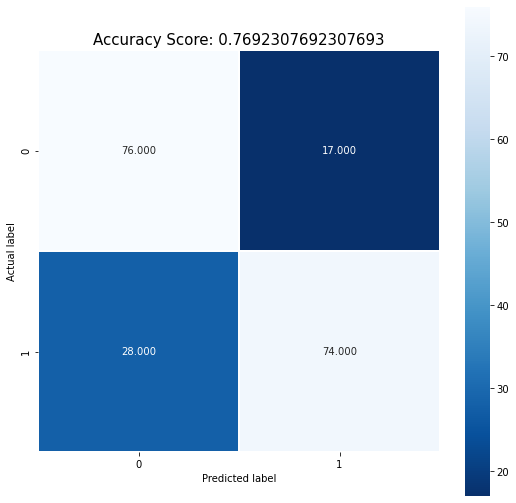

In [23]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, predicted_mnb)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_mnb)
plt.title(all_sample_title, size = 15);
#plt.show();

1758

# Train final model on full training set

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(training_data_large['Comment'],training_data_large['Pos/Neg'], test_size = .2, random_state = 42)

In [33]:
text_clf_mnb_full = Pipeline([('vect', TfidfVectorizer(max_df = 0.9, max_features=900, ngram_range = (1, 1))),('clf-mnb', MultinomialNB(alpha=0.5, fit_prior=True))])
text_clf_mnb_full = text_clf_mnb_full.fit(X_train, Y_train)

predicted_mnb_full = text_clf_mnb_full.predict(X_test)
accuracy_mnb_full = np.mean(predicted_mnb_full == Y_test)
print(accuracy_mnb_full)

0.7906712172923777


In [ ]:
0.764102564102564
{'clf-mnb__alpha': 0.5, 'clf-mnb__fit_prior': True, 'vect__max_df': 0.9, 'vect__max_features': 900, 'vect__ngram_range': (1, 1)}

In [27]:
predicted_mnb_full.shape

(1758,)

In [28]:
predicted_mnb_test = text_clf_mnb_full.predict(test_data['Comment'])
accuracy_mnb_test = np.mean(predicted_mnb_test == test_data['Pos/Neg'])
print(accuracy_mnb_test)

0.8545918367346939


In [29]:
accuracy_mnb_full

0.7963594994311718

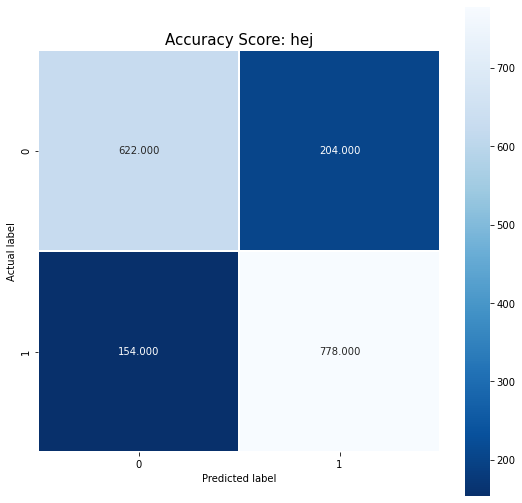

In [30]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, predicted_mnb_full)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('hej')
plt.title(all_sample_title, size = 15);
#plt.show();